In [322]:
import MutationalSignatures.compiled_functions as cf
from MutationalSignatures.SignatureMatrix import SignatureMatrix
from MutationalSignatures.SignaturePreprocessor import SignaturePreprocessor 

import matplotlib
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import sklearn
import numpy as np
from scipy.optimize import nnls
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
sig_matrix = SignatureMatrix(multiAlignmentPath=None, 
                                refPath="", 
                                trinucleotide_file = "")
sig_matrix.addMetadata()

In [170]:
valid_weeks = sig_matrix.get_trinucleotide_matrix_metadata().epi_week.value_counts()[sig_matrix.get_trinucleotide_matrix_metadata().epi_week.value_counts()>500]
meta = sig_matrix.get_trinucleotide_matrix_metadata()[sig_matrix.get_trinucleotide_matrix_metadata().epi_week.isin(valid_weeks.index)]
data = sig_matrix.get_trinucleotide_matrix()[sig_matrix.get_trinucleotide_matrix_metadata().epi_week.isin(valid_weeks.index)]

In [3]:
signature_columns = data.columns 

In [323]:
def pseudosample(table,signature_columns,feature_name):
    pseudosample = table.groupby(feature_name)[signature_columns].sum().reset_index()
    pseudosample = pseudosample.sort_values(by=[feature_name])
    pseudosample = pseudosample.set_index(feature_name)
    return pseudosample

In [320]:
feature ='epi_week'

In [330]:
pseudosampled_dataframe = pseudosample(pd.merge(data,meta,left_index=True,right_index=True),signature_columns,feature)
pseudosampled_dataframe.index = pseudosampled_dataframe.index.astype(int)
pseudosampled_dataframe = pseudosampled_dataframe.sort_index()
pseudosampled_dataframe

,AC-AAA,AC-AAC,AC-AAG,AC-AAT,AC-CAA,AC-CAC,AC-CAG,AC-CAT,AC-GAA,AC-GAC,...,TG-CTG,TG-CTT,TG-GTA,TG-GTC,TG-GTG,TG-GTT,TG-TTA,TG-TTC,TG-TTG,TG-TTT
epi_week,,,,,,,,,,,,,,,,,,,,,
10,21,1,8,11,5,1,0,3,6,2,...,3,7,2,1,2,9,6,4,2,6
11,36,13,20,12,17,7,4,11,16,7,...,3,6,3,1,11,10,13,13,11,18
12,56,16,22,26,19,10,8,22,17,2,...,13,13,12,11,8,24,19,21,20,32
13,63,13,27,21,17,8,18,20,26,8,...,15,18,8,3,6,16,15,20,19,36
14,63,23,31,39,23,5,10,16,29,10,...,21,31,5,4,6,24,28,24,19,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,58,19,73,82,33,30,31,39,54,25,...,47,88,8,12,19,45,20,66,39,62
143,59,35,77,70,41,12,31,34,57,22,...,34,62,4,20,19,29,21,48,47,69
144,43,30,57,59,13,16,29,26,50,15,...,40,52,8,16,11,22,27,38,34,44


In [ ]:
def get_sequence_from_genbank(genbank_file):
    with open(genbank_file, "r") as handle:
        record = SeqIO.read(handle, "genbank")
    return record.seq

In [709]:
from Bio import SeqIO
seq = str(get_sequence_from_genbank('GISAID_REFERENCE.gb'))
trimer_composition = {}

for i in range(3,len(seq)):
    if seq[i-3:i] not in trimer_composition:
        trimer_composition[seq[i-3:i]] = 1
    else:
        trimer_composition[seq[i-3:i]]+=1
compositions = pd.DataFrame(trimer_composition,index=[0])
composition_dataframe=pd.merge(pd.DataFrame([data.columns.str[:2],data.columns.str[3:]]).T,pd.DataFrame(compositions).T,left_on=1,right_index=True)
composition_dataframe.index = composition_dataframe['0_x']+'-'+composition_dataframe[1]
composition_dataframe
composition_dataframe = composition_dataframe.drop(['0_x',1],axis=1)
composition_series = pd.Series(composition_dataframe['0_y'],composition_dataframe.index,name='index').sort_index()
# composition_series = composition_series/composition_series.sum()
composition_series

AC-AAA     922
AC-AAC     615
AC-AAG     580
AC-AAT     761
AC-CAA     703
          ... 
TG-GTT     700
TG-TTA     876
TG-TTC     518
TG-TTG     817
TG-TTT    1004
Name: index, Length: 192, dtype: int64

In [733]:
composition_as_percentage = compositions
composition_as_percentage = (composition_as_percentage.T/composition_as_percentage.T.sum()).T
composition_as_percentage_dataframe=pd.merge(pd.DataFrame([data.columns.str[:2],data.columns.str[3:]]).T,pd.DataFrame(composition_as_percentage).T,left_on=1,right_index=True)
composition_as_percentage_dataframe.index = composition_as_percentage_dataframe['0_x']+'-'+composition_as_percentage_dataframe[1]
composition_as_percentage_dataframe
composition_as_percentage_dataframe = composition_as_percentage_dataframe.drop(['0_x',1],axis=1)
composition_as_percentage_dataframe = pd.Series(composition_as_percentage_dataframe['0_y'],composition_as_percentage_dataframe.index,name='index').sort_index()
composition_as_percentage_dataframe
# composition_as_percentage_dataframe.plot(kind='bar')

AC-AAA    0.030836
AC-AAC    0.020569
AC-AAG    0.019398
AC-AAT    0.025452
AC-CAA    0.023512
            ...   
TG-GTT    0.023411
TG-TTA    0.029298
TG-TTC    0.017324
TG-TTG    0.027324
TG-TTT    0.033579
Name: index, Length: 192, dtype: float64

In [326]:
composition_series.index_name = 'Mutation'

In [714]:
normalised_data = pseudosampled_dataframe.T.sort_index().T/composition_series.values
normalised_data

,AC-AAA,AC-AAC,AC-AAG,AC-AAT,AC-CAA,AC-CAC,AC-CAG,AC-CAT,AC-GAA,AC-GAC,...,TG-CTG,TG-CTT,TG-GTA,TG-GTC,TG-GTG,TG-GTT,TG-TTA,TG-TTC,TG-TTG,TG-TTT
epi_week,,,,,,,,,,,,,,,,,,,,,
10,0.022777,0.001626,0.013793,0.014455,0.007112,0.002179,0.000000,0.006198,0.011215,0.005882,...,0.006061,0.009485,0.004264,0.003717,0.003623,0.012857,0.006849,0.007722,0.002448,0.005976
11,0.039046,0.021138,0.034483,0.015769,0.024182,0.015251,0.009132,0.022727,0.029907,0.020588,...,0.006061,0.008130,0.006397,0.003717,0.019928,0.014286,0.014840,0.025097,0.013464,0.017928
12,0.060738,0.026016,0.037931,0.034166,0.027027,0.021786,0.018265,0.045455,0.031776,0.005882,...,0.026263,0.017615,0.025586,0.040892,0.014493,0.034286,0.021689,0.040541,0.024480,0.031873
13,0.068330,0.021138,0.046552,0.027595,0.024182,0.017429,0.041096,0.041322,0.048598,0.023529,...,0.030303,0.024390,0.017058,0.011152,0.010870,0.022857,0.017123,0.038610,0.023256,0.035857
14,0.068330,0.037398,0.053448,0.051248,0.032717,0.010893,0.022831,0.033058,0.054206,0.029412,...,0.042424,0.042005,0.010661,0.014870,0.010870,0.034286,0.031963,0.046332,0.023256,0.031873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.062907,0.030894,0.125862,0.107753,0.046942,0.065359,0.070776,0.080579,0.100935,0.073529,...,0.094949,0.119241,0.017058,0.044610,0.034420,0.064286,0.022831,0.127413,0.047736,0.061753
143,0.063991,0.056911,0.132759,0.091984,0.058321,0.026144,0.070776,0.070248,0.106542,0.064706,...,0.068687,0.084011,0.008529,0.074349,0.034420,0.041429,0.023973,0.092664,0.057528,0.068725
144,0.046638,0.048780,0.098276,0.077530,0.018492,0.034858,0.066210,0.053719,0.093458,0.044118,...,0.080808,0.070461,0.017058,0.059480,0.019928,0.031429,0.030822,0.073359,0.041616,0.043825


# Decompose Global Exposures

In [176]:
N=3

In [178]:
normalised = "Normalised_Signatures"
traditional="Full"

# traditional="Traditional"

In [979]:
signatures = pd.read_csv(f'Resources/Observable_Exports/{normalised}/{traditional}/N{N}/Clustered_Final_Signatures_N{N}.csv',index_col='Mutation')
# signatures.columns = ['Signature_'+sig for sig in signatures.columns]
signatures

,Signature_0,Signature_1,Signature_2
Mutation,,,
AC-AAA,0.0,0.0,0.0
AC-AAC,0.0,0.0,0.0
AC-AAG,0.0,0.0,0.0
AC-AAT,0.0,0.0,0.0
AC-CAA,0.0,0.0,0.0
...,...,...,...
TG-GTT,0.0,0.0,0.0
TG-TTA,0.0,0.0,0.0
TG-TTC,0.0,0.0,0.0


<AxesSubplot:xlabel='Mutation'>

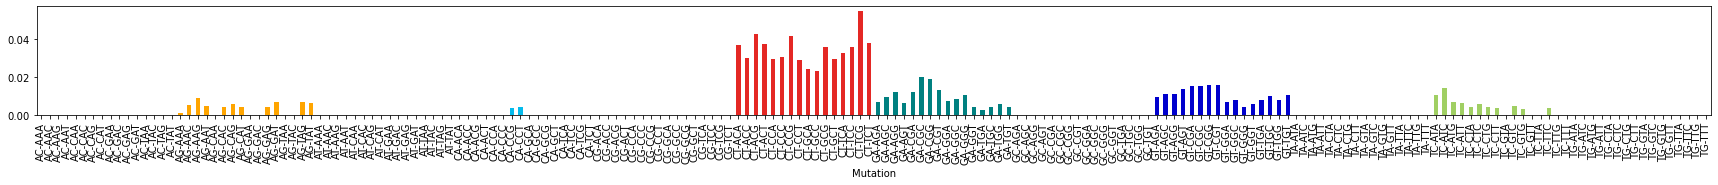

In [980]:
fig,ax = plt.subplots(figsize=[30,2])
(signatures['Signature_0']).plot(x='Mutation',y='Signature_1',kind='bar',color=melted_residuals['sub_colour'],ax=ax)

<AxesSubplot:xlabel='Mutation'>

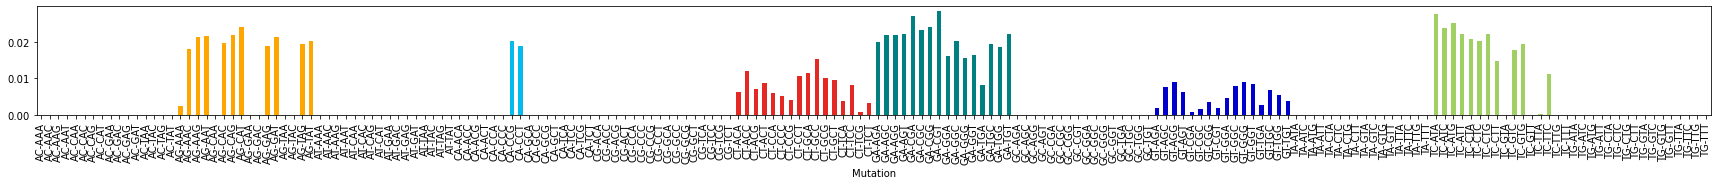

In [981]:
fig,ax = plt.subplots(figsize=[30,2])
(signatures['Signature_1']).plot(x='Mutation',y='Signature_2',kind='bar',color=melted_residuals['sub_colour'],ax=ax)

<AxesSubplot:xlabel='Mutation'>

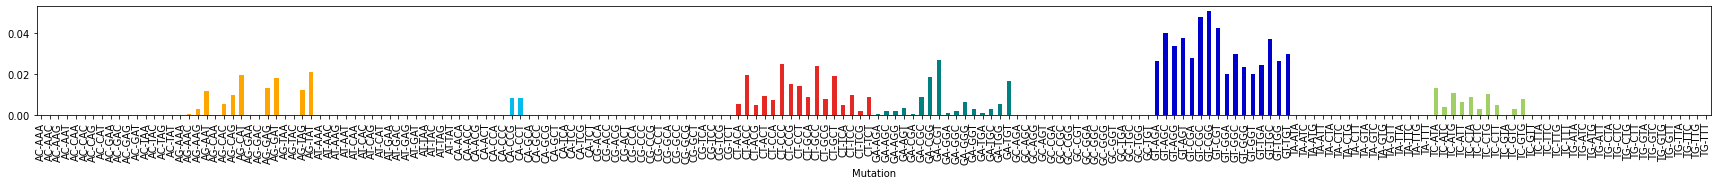

In [982]:
fig,ax = plt.subplots(figsize=[30,2])
(signatures['Signature_2']).plot(x='Mutation',y='Signature_3',kind='bar',color=melted_residuals['sub_colour'],ax=ax)

# Return Signatures to SARS-CoV-2 Domain

In [983]:
codon_biased_signatures = signatures

In [984]:
for sig in codon_biased_signatures.columns:
    codon_biased_signatures[sig] = codon_biased_signatures[sig] *composition_as_percentage_dataframe
    codon_biased_signatures[sig] = codon_biased_signatures[sig]/codon_biased_signatures[sig].sum()

<AxesSubplot:xlabel='Mutation'>

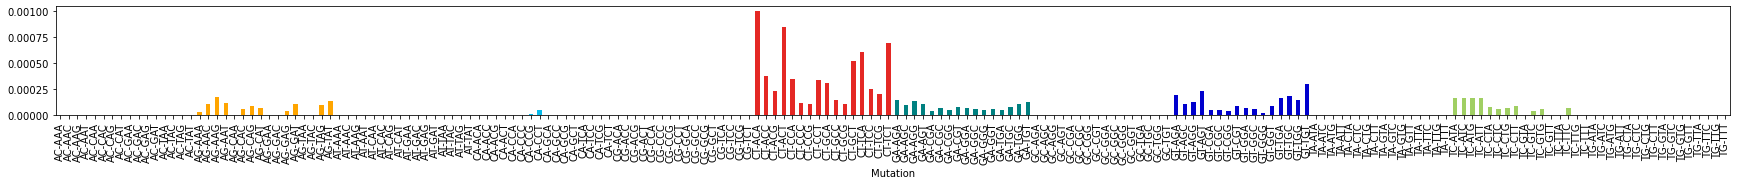

In [985]:
fig,ax = plt.subplots(figsize=[30,2])
(codon_biased_signatures['Signature_0']).plot(x='Mutation',y='Signature_0',kind='bar',color=melted_residuals['sub_colour'],ax=ax)

<AxesSubplot:xlabel='Mutation'>

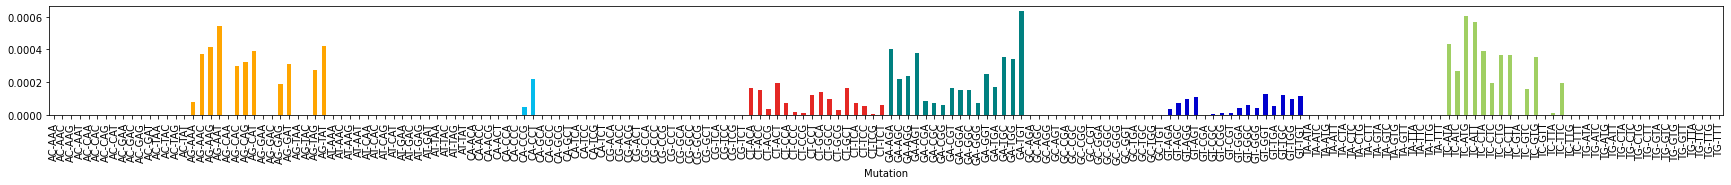

In [986]:
fig,ax = plt.subplots(figsize=[30,2])
(codon_biased_signatures['Signature_1']).plot(x='Mutation',y='Signature_1',kind='bar',color=melted_residuals['sub_colour'],ax=ax)

<AxesSubplot:xlabel='Mutation'>

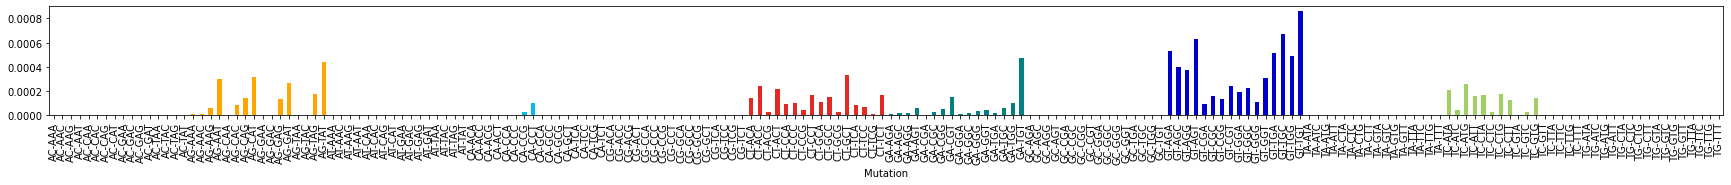

In [987]:
fig,ax = plt.subplots(figsize=[30,2])
(codon_biased_signatures['Signature_2']).plot(x='Mutation',y='Signature_2',kind='bar',color=melted_residuals['sub_colour'],ax=ax)

In [973]:
codon_biased_signatures.to_csv('Resources/Observable_Exports/Reviewer_Normalised_Signatures/Full/N3/Codon_Biased_Clustered_Final_Signatures_N3.csv')

## Normalised Input Data?

In [988]:
signature_cols = signatures.columns

In [989]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(codon_biased_signatures[signature_cols].values,pseudosampled_dataframe.T, test_size=0.2)

reg_nnls = LinearRegression(positive=True)
y_pred_nnls = reg_nnls.fit(X_train, y_train).predict(X_test)
r2_score_nnls = r2_score(y_test, y_pred_nnls)
print("NNLS R2 score", r2_score_nnls)

NNLS R2 score 0.8855742764402736


<AxesSubplot:>

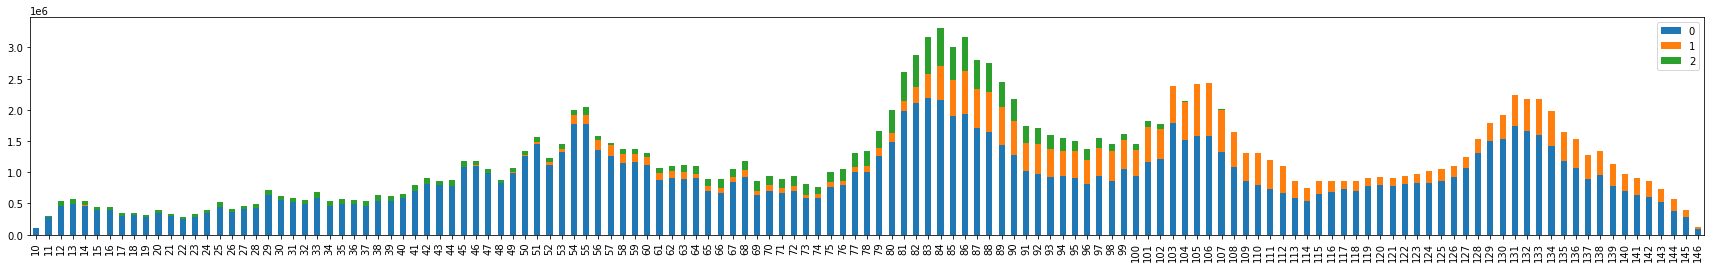

In [990]:
fig,ax = plt.subplots(figsize=[30,4])
full_reg =  LinearRegression(positive=True)
full_reg.fit(codon_biased_signatures[signature_cols].values ,pseudosampled_dataframe.T)
global_exposures = pd.DataFrame(full_reg.coef_)
global_exposures.index = pseudosampled_dataframe.index.values
global_exposures.plot(kind='bar',stacked=True,ax=ax)

<AxesSubplot:>

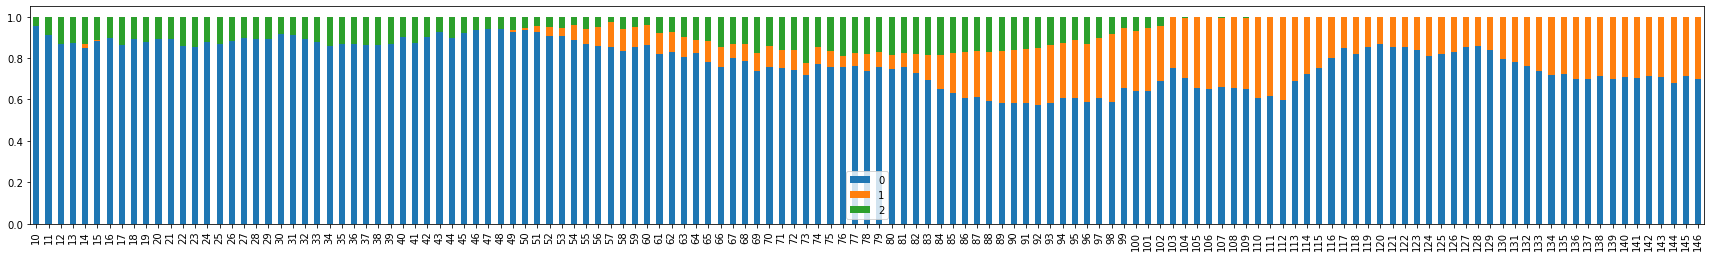

In [991]:
fig,ax = plt.subplots(figsize=[30,4])
(global_exposures.T/global_exposures.T.sum()).T.plot(kind='bar',stacked=True,ax=ax)

In [992]:
global_exposures.columns = ['Signature_'+str(col) for col in global_exposures.columns]
global_exposures['Weekly_Sum'] = global_exposures.sum(axis=1)
global_exposures = global_exposures.reset_index()
global_exposures.rename(columns={'index':'Epi_Week'},inplace=True)
global_exposures

,Epi_Week,Signature_0,Signature_1,Signature_2,Weekly_Sum
0,10,104222.882240,0.000000,5057.827685,109280.709925
1,11,278991.732957,0.000000,26837.292317,305829.025274
2,12,465340.880825,0.000000,72055.088160,537395.968985
3,13,495079.451427,0.000000,73495.637789,568575.089216
4,14,460799.303232,11216.357695,71960.626291,543976.287218
...,...,...,...,...,...
132,142,608261.337846,244400.689901,0.000000,852662.027747
133,143,520448.598276,213290.198292,0.000000,733738.796568
134,144,382201.070836,182013.249659,0.000000,564214.320495
135,145,279871.101794,112988.619964,0.000000,392859.721758


In [994]:
melted_exposure = global_exposures.melt(id_vars=['Epi_Week','Weekly_Sum'])
melted_exposure.columns = ['Epi_Week','Weekly_Sum','Signature','Absolute_Exposure']
melted_exposure

,Epi_Week,Weekly_Sum,Signature,Absolute_Exposure
0,10,109280.709925,Signature_0,104222.882240
1,11,305829.025274,Signature_0,278991.732957
2,12,537395.968985,Signature_0,465340.880825
3,13,568575.089216,Signature_0,495079.451427
4,14,543976.287218,Signature_0,460799.303232
...,...,...,...,...
406,142,852662.027747,Signature_2,0.000000
407,143,733738.796568,Signature_2,0.000000
408,144,564214.320495,Signature_2,0.000000
409,145,392859.721758,Signature_2,0.000000


In [995]:
melted_exposure['Exposure'] = melted_exposure.Absolute_Exposure/melted_exposure.Weekly_Sum
melted_exposure.drop('Weekly_Sum',inplace=True,axis=1)
melted_exposure

,Epi_Week,Signature,Absolute_Exposure,Exposure
0,10,Signature_0,104222.882240,0.953717
1,11,Signature_0,278991.732957,0.912247
2,12,Signature_0,465340.880825,0.865918
3,13,Signature_0,495079.451427,0.870737
4,14,Signature_0,460799.303232,0.847094
...,...,...,...,...
406,142,Signature_2,0.000000,0.000000
407,143,Signature_2,0.000000,0.000000
408,144,Signature_2,0.000000,0.000000
409,145,Signature_2,0.000000,0.000000


In [748]:
melted_exposure.to_csv('Resources/Observable_Exports/Reviewer_Normalised_Signatures/Full/N3/NNLS_Global_Exposure.csv',index=False)


# Continent Exposures

In [996]:
meta['Continent'] = meta.FullCountry.str.split('/',expand=True)[0]

In [997]:
continents = meta.Continent.unique()
continents

array(['ASIA', 'EUROPE', 'NORTH_AMERICA', 'SOUTH_AMERICA', 'OCEANIA',
       'AFRICA'], dtype=object)

In [998]:
continent_pseudosampled_dataframes = {}
for continent in continents:
    continent_data = pd.merge(data,meta,left_index=True,right_index=True)
    continent_data = continent_data[continent_data.Continent == continent]
    continent_data = pseudosample(continent_data,signature_columns,feature)
    continent_data.index = continent_data.index.astype(int)
    continent_data = continent_data.sort_index()
    continent_pseudosampled_dataframes[continent] = continent_data

In [999]:
continent_pseudosampled_results = {}
for continent in continents:
    continent_reg =  LinearRegression(positive=True)
    continent_reg.fit(codon_biased_signatures[signature_cols].values ,continent_pseudosampled_dataframes[continent].T)
    continent_reg = pd.DataFrame(continent_reg.coef_)
    continent_reg.index = continent_pseudosampled_dataframes[continent].index
    continent_reg["Continent"] = continent
    continent_pseudosampled_results[continent] = continent_reg

<AxesSubplot:xlabel='epi_week'>

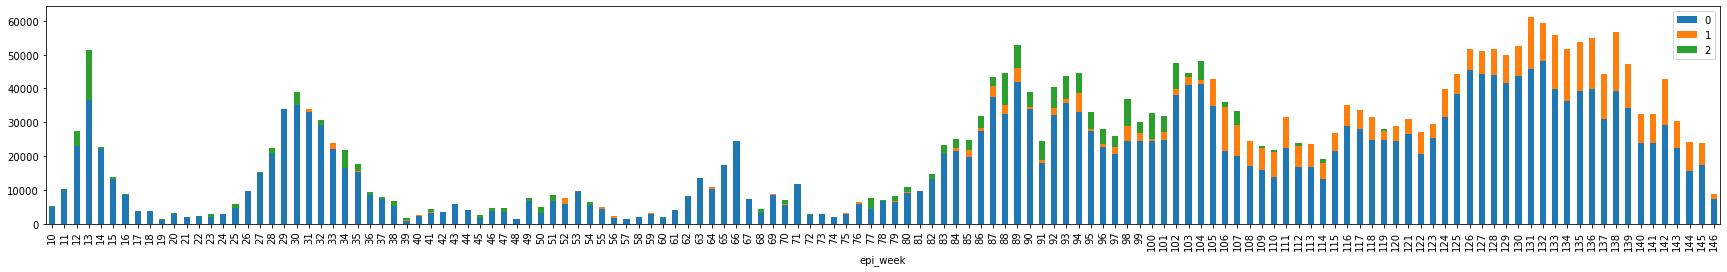

In [1000]:
fig,ax = plt.subplots(figsize=[30,4])
continent_pseudosampled_results['OCEANIA'].plot(kind='bar',stacked=True,ax=ax)

In [754]:
master_continent_dataframe = []
for continent in continents:
    continent_pseudosampled_results[continent].columns = ['Signature_'+str(col) for col in continent_pseudosampled_results[continent].columns[:-1]]+['Continent']
    continent_pseudosampled_results[continent]['Weekly_Sum'] = continent_pseudosampled_results[continent].sum(axis=1)
    continent_pseudosampled_results[continent] = continent_pseudosampled_results[continent].reset_index()
    continent_pseudosampled_results[continent].rename(columns={'epi_week':'Epi_Week'},inplace=True)
    continent_pseudosampled_results[continent] = continent_pseudosampled_results[continent].melt(id_vars=["Continent",'Epi_Week','Weekly_Sum'])
    continent_pseudosampled_results[continent].rename(columns={'variable':'Signature','value':'Absolute_Exposure'},inplace=True)
    continent_pseudosampled_results[continent]['Exposure'] = continent_pseudosampled_results[continent].Absolute_Exposure/continent_pseudosampled_results[continent].Weekly_Sum
    continent_pseudosampled_results[continent].drop('Weekly_Sum',axis=1,inplace=True)
    master_continent_dataframe.append(continent_pseudosampled_results[continent])

/home4/2191618l/.conda/envs/signatures/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [756]:
pd.concat(master_continent_dataframe,axis=0).to_csv('Resources/Observable_Exports/Reviewer_Normalised_Signatures/Full/N3/NNLS_Continent_Exposure.csv')

# VOC Exposures

In [449]:
import json
with open("pango_aliases.json") as json_file:
        lins = json.load(json_file)
def is_voc(lineage,voc_dictionary):

    for key,values in voc_dictionary.items():
        if "." in lineage:
            start  = lineage.split(".")[0]
        else:
            start  = lineage
        #If base VOC lineage 
        if lineage in values:
            return key
        #If not the base VOC
        else:
            if start in values:
                return key
            elif values[0]+"." in lineage:
                return key
    return "Non-VOC"

def build_voc_dictionary(lineage_dict):
    vocs = {"Alpha":["B.1.1.7"],"Beta":["B.1.351"],"Gamma":["P.1"],"Delta":["B.1.617.2"],"Omicron":["B.1.1.529"]}
    
    for key in lineage_dict.keys():
        val = lineage_dict[key]
        if type(val) == str:
            val = [val]
            
        for lineage in val:
            if "." in lineage:
                start  = lineage.split(".")[0]
            else:
                start  = lineage
            if "B.1.617.2" == lineage or "B.1.617.2." in lineage or start in vocs["Delta"] :
                vocs["Delta"].append(key)
            elif "B.1.1.7" == lineage or  "B.1.1.7." in lineage or start in vocs["Alpha"]:
                vocs["Alpha"].append(key)
            elif "B.1.351" == lineage or "B.1.351." in lineage or start in vocs["Beta"]:
                vocs["Beta"].append(key)
            elif "P.1" == lineage or  lineage == "P.1" or "P.1." in lineage or start in vocs["Gamma"]:
                vocs["Gamma"].append(key)
            elif "B.1.1.529" == lineage or "B.1.1.529." in lineage or start in vocs["Omicron"]:
                vocs["Omicron"].append(key)
    return vocs

In [757]:
voc_dict = build_voc_dictionary(lins)
meta["VOC"] = [is_voc(lineage,voc_dict) for lineage in meta.lineage]

In [758]:
vocs = meta.VOC.unique()
vocs

array(['Delta', 'Non-VOC', 'Omicron', 'Alpha', 'Gamma', 'Beta'],
      dtype=object)

In [759]:
voc_pseudosampled_dataframes = {}
for voc in vocs:
    voc_data = pd.merge(data,meta,left_index=True,right_index=True)
    voc_data = voc_data[voc_data.VOC == voc]
    epi_week_counts = (voc_data[feature].value_counts())
    epi_week_counts.index = epi_week_counts.index.astype(int)
    epi_week_counts = epi_week_counts.sort_index()
    voc_data = pseudosample(voc_data,signature_columns,feature)
    voc_data.index = voc_data.index.astype(int)
    voc_data = voc_data.sort_index()
    voc_pseudosampled_dataframes[voc] = voc_data[epi_week_counts >20]
    voc_pseudosampled_dataframes = voc_pseudosampled_dataframes

In [760]:
voc_pseudosampled_dataframes.keys()

dict_keys(['Delta', 'Non-VOC', 'Omicron', 'Alpha', 'Gamma', 'Beta'])

In [761]:
voc_pseudosampled_results = {}
for voc in vocs:
    voc_reg =  LinearRegression(positive=True)
    voc_reg.fit(codon_biased_signatures[signature_cols].values ,voc_pseudosampled_dataframes[voc].T)
    voc_reg = pd.DataFrame(voc_reg.coef_)
    voc_reg.index = voc_pseudosampled_dataframes[voc].index
    voc_reg['VOC'] = voc
    voc_pseudosampled_results[voc] = voc_reg
    

In [764]:
master_voc_dataframe = []
for voc in vocs:
    voc_pseudosampled_results[voc].columns = ['Signature_'+str(col) for col in voc_pseudosampled_results[voc].columns[:-1]]+['VOC']
    voc_pseudosampled_results[voc]['Weekly_Sum'] = voc_pseudosampled_results[voc].sum(axis=1)
    voc_pseudosampled_results[voc] = voc_pseudosampled_results[voc].reset_index()
    voc_pseudosampled_results[voc].rename(columns={'epi_week':'Epi_Week'},inplace=True)
    voc_pseudosampled_results[voc] = voc_pseudosampled_results[voc].melt(id_vars=["VOC",'Epi_Week','Weekly_Sum'])
    voc_pseudosampled_results[voc].rename(columns={'variable':'Signature','value':'Absolute_Exposure'},inplace=True)
    voc_pseudosampled_results[voc]['Exposure'] = voc_pseudosampled_results[voc].Absolute_Exposure/voc_pseudosampled_results[voc].Weekly_Sum
    voc_pseudosampled_results[voc].drop('Weekly_Sum',axis=1,inplace=True)
    master_voc_dataframe.append(voc_pseudosampled_results[voc])

/home4/2191618l/.conda/envs/signatures/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [765]:
pd.concat(master_voc_dataframe,axis=0).to_csv('NNLS_VOC_Exposure.csv')

# Wastewater Exposures

In [830]:
wastewater = pd.read_csv('Wastewater_Data_normalised_signature_matrix.csv')
# wastewater = wastewater.set_index('Sequence_Name')

In [831]:
wastewater['YearMonth'] = wastewater.Sequence_Name.str.split('|',expand=True)[2].str[:7]

In [832]:
wastewater['YearMonth']

0       2021-08
1       2022-07
2       2021-12
3       2021-12
4       2021-12
         ...   
1358    2022-01
1359    2021-10
1360    2021-03
1361    2021-10
1362    2021-11
Name: YearMonth, Length: 1363, dtype: object

In [840]:
YearMonthPseudo = pseudosample(wastewater.drop('Sequence_Name',axis=1),signature_columns,'YearMonth')
YearMonthPseudo

,AC-AAA,AC-AAC,AC-AAG,AC-AAT,AC-CAA,AC-CAC,AC-CAG,AC-CAT,AC-GAA,AC-GAC,...,TG-CTG,TG-CTT,TG-GTA,TG-GTC,TG-GTG,TG-GTT,TG-TTA,TG-TTC,TG-TTG,TG-TTT
YearMonth,,,,,,,,,,,,,,,,,,,,,
2020-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-12,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-01,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,0,0
2021-02,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2021-03,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2021-04,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,2,0,0,0,2
2021-06,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2021-07,0,1,0,0,0,0,1,1,1,0,...,15,0,0,0,0,0,0,0,0,0


In [844]:
waste_reg =  LinearRegression(positive=True)
waste_reg.fit(codon_biased_signatures[signature_cols].values ,YearMonthPseudo.T)
waste_reg = pd.DataFrame(waste_reg.coef_)
waste_reg.index = YearMonthPseudo.index
waste_reg.columns = ['Signature 1', 'Signature 2','Signature 3']
waste_reg

,Signature 1,Signature 2,Signature 3
YearMonth,,,
2020-04,3.602335,0.000000,0.000000
2020-12,31.868067,0.000000,5.760747
2021-01,86.995017,0.000000,0.000000
2021-02,149.736872,0.000000,12.793547
2021-03,99.898007,14.787840,0.000000
2021-04,134.050795,0.000000,0.000000
2021-05,123.504615,0.000000,0.000000
2021-06,43.859387,0.000000,5.276156
2021-07,514.678619,0.000000,135.675766


In [874]:
(waste_reg.T/waste_reg.T.sum()).T.reset_index().melt(id_vars=['YearMonth']).to_csv('Megan_WasteWater_Updated.csv')

In [875]:
(waste_reg.T/waste_reg.T.sum()).T.reset_index()

,YearMonth,Signature 1,Signature 2,Signature 3
0,2020-04,1.000000,0.000000,0.000000
1,2020-12,0.846906,0.000000,0.153094
2,2021-01,1.000000,0.000000,0.000000
3,2021-02,0.921285,0.000000,0.078715
4,2021-03,0.871058,0.128942,0.000000
5,2021-04,1.000000,0.000000,0.000000
6,2021-05,1.000000,0.000000,0.000000
7,2021-06,0.892620,0.000000,0.107380
8,2021-07,0.791382,0.000000,0.208618
9,2021-08,0.853936,0.000000,0.146064


In [951]:

YearMonthPseudoCounts = YearMonthPseudo.reset_index().melt(id_vars='YearMonth')

In [952]:
YearMonthPseudoCounts

,YearMonth,variable,value
0,2020-04,AC-AAA,0
1,2020-12,AC-AAA,0
2,2021-01,AC-AAA,0
3,2021-02,AC-AAA,1
4,2021-03,AC-AAA,0
...,...,...,...
4603,2022-06,TG-TTT,2
4604,2022-07,TG-TTT,2
4605,2022-08,TG-TTT,1
4606,2022-10,TG-TTT,0


In [953]:
maximum_likelihood = pd.DataFrame(signatures.idxmax(axis=1),columns=["Signature"])
maximum_likelihood['Unattributed'] = list((signatures.sum(axis=1)==0).values)
maximum_likelihood.Signature = ["Unattributed" if maximum_likelihood.iloc[i].Unattributed == True else maximum_likelihood.iloc[i].Signature for i in range(len(maximum_likelihood))]
maximum_likelihood

,Signature,Unattributed
Mutation,,
AC-AAA,Unattributed,True
AC-AAC,Unattributed,True
AC-AAG,Unattributed,True
AC-AAT,Unattributed,True
AC-CAA,Unattributed,True
...,...,...
TG-GTT,Unattributed,True
TG-TTA,Unattributed,True
TG-TTC,Unattributed,True


In [954]:
YearMonthPseudoCounts = pd.merge(maximum_likelihood,YearMonthPseudoCounts,left_index=True,right_on='variable').drop('Unattributed',axis=1)

In [955]:
def assign_range(date):
    if datetime.strptime(date,'%Y-%m') < datetime.strptime("2021-07",'%Y-%m'):
        return "2021-Jan-Jun"
    elif datetime.strptime(date,'%Y-%m') >= datetime.strptime("2021-07",'%Y-%m') and datetime.strptime(date,'%Y-%m') < datetime.strptime("2022-01",'%Y-%m'):
        return '2021-Jul-Dec'
    elif datetime.strptime(date,'%Y-%m') >= datetime.strptime("2022-01",'%Y-%m') and datetime.strptime(date,'%Y-%m') < datetime.strptime("2022-07",'%Y-%m'):
        return "2022-Jan-Jun" 
    elif datetime.strptime(date,'%Y-%m') >= datetime.strptime("2022-07",'%Y-%m') and datetime.strptime(date,'%Y-%m') < datetime.strptime("2023-01",'%Y-%m'):
        return "2022-Jul-Dec" 
        

In [956]:
YearMonthPseudoCounts['Range'] = [assign_range(date) for date in YearMonthPseudoCounts.YearMonth]

In [965]:
YearMonthPseudoCounts = YearMonthPseudoCounts.groupby(['Signature','Range','YearMonth']).sum().reset_index()

In [966]:
YearMonthPseudoCounts['log_mutation_counts'] = np.log(YearMonthPseudoCounts.value)

/home4/2191618l/.conda/envs/signatures/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [967]:
YearMonthPseudoCounts.rename(columns = {'value':'mutation_count','Range':'date'}).to_csv('YearMonthPseudoCounts.csv')

In [968]:
YearMonthPseudoCounts

,Signature,Range,YearMonth,value,log_mutation_counts
0,Signature_0,2021-Jan-Jun,2020-04,3,1.098612
1,Signature_0,2021-Jan-Jun,2020-12,18,2.890372
2,Signature_0,2021-Jan-Jun,2021-01,54,3.988984
3,Signature_0,2021-Jan-Jun,2021-02,99,4.595120
4,Signature_0,2021-Jan-Jun,2021-03,57,4.043051
...,...,...,...,...,...
91,Unattributed,2022-Jan-Jun,2022-06,92,4.521789
92,Unattributed,2022-Jul-Dec,2022-07,63,4.143135
93,Unattributed,2022-Jul-Dec,2022-08,45,3.806662
94,Unattributed,2022-Jul-Dec,2022-10,1,0.000000
